Importando las librerías necesarias
En primer lugar, vamos a importar las librerías necesarias. Importaremos las librerías de numpy, TensorFlow (éste será el framework sobre el que correrá Keras), Keras y unas librerías necesarias Scikit Learn, Pandas, etc.

In [2]:
import numpy as np  
from scipy import misc  
from PIL import Image  
import glob  
import matplotlib.pyplot as plt  
import scipy.misc  
from matplotlib.pyplot import imshow  
%matplotlib inline
from IPython.display import SVG  
import cv2  
import seaborn as sn  
import pandas as pd  
import pickle  
from keras import layers  
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout  
from keras.models import Sequential, Model, load_model  
from keras.preprocessing import image  
from keras.preprocessing.image import load_img  
from keras.preprocessing.image import img_to_array  
from keras.applications.imagenet_utils import decode_predictions  
from keras.utils import layer_utils, np_utils  
from keras.utils.data_utils import get_file  
from keras.applications.imagenet_utils import preprocess_input  
from keras.utils.vis_utils import model_to_dot  
from keras.utils.vis_utils import plot_model  
from keras.initializers import glorot_uniform  
from keras import losses  
import keras.backend as K  
from keras.callbacks import ModelCheckpoint  
from sklearn.metrics import confusion_matrix, classification_report  
import tensorflow as tf  

Preparando el conjunto de datos

Para el experimento, usaremos el conjunto de datos ampliamente usado CIFAR-100. Este conjunto de datos consta de 600 imágenes por cada clase de un total de 100 clases. Se divide en 500 imágenes para entrenamiento y 100 imágenes para validación por cada clase. Las 100 clases están agrupadas en 20 superclases. Cada imagen tiene una etiqueta "fina" (la clase, de entre las 100, a la que pertenece) y una etiqueta "gruesa" (correspondiente a su superclase).

El framework de Keras incluye el módulo para descargarlo directamente:

In [3]:
from keras.datasets import cifar100

(x_train_original, y_train_original), (x_test_original, y_test_original) = cifar100.load_data(label_mode='fine')

Actualmente, hemos descargado los datasets de entrenamiento y validación. x_train_original y x_test_original son los conjuntos de datos con lás imágenes de entrenamiento y validación respectivamente, mientras que y_train_original y y_test_original son los datasets con las etiquetas.

Veamos la forma de y_train_original:
    array([[19], [29], [ 0], ..., [ 3], [ 7], [73]])  
    
Como se puede ver, se trata de un array donde cada número se corresponde con la etiqueta concreta. Lo primero que hay que hacer es convertir este array en su versión one-hot-encoding    

In [4]:
y_train = np_utils.to_categorical(y_train_original, 100)
y_test = np_utils.to_categorical(y_test_original, 100)

Bien, representa la imagen en los 3 canales RGB de 256 píxeles. Vamos a verla:

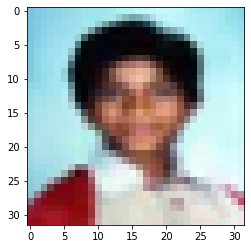

In [5]:
imgplot = plt.imshow(x_train_original[3])
plt.show()

Lo que haremos a continuación, es normalizar las imágenes. Esto es, dividiremos cada elemento de x_train_original y xtestoriginal por el numero de píxeles, es decir, 255. Con esto obtenemos que el array comprenderá valores de entre 0 y 1. Con esto el entrenamiento suele aportar mejores resultados.

In [6]:
x_train = x_train_original/255  
x_test = x_test_original/255  

Preparando el entorno
El siguiente paso es definir ciertos parámetros sobre el experimento en Keras. Lo primero será especificar a Keras dónde se encuentran los canales. En un array de imágenes, pueden venir como último indice o como el primero. Esto se conoce como canales primero (channels first) o canales al final (channels last). En nuestro caso, vamos a definirlos al final.

In [7]:
K.set_image_data_format('channels_last')  

Lo siguiente que vamos a especificar es la fase del experimento. En este caso, la fase será de entrenamiento:

In [9]:
K.set_learning_phase(True)  

Entrenando una red neuronal sencilla
En primer lugar, vamos a entrenar una red neuronal sencilla. Definimos un procedimiento que nos devuelva una red neuronal:

In [10]:
def create_simple_nn():  
  model = Sequential()
  model.add(Flatten(input_shape=(32, 32, 3), name="Input_layer"))
  model.add(Dense(1000, activation='relu', name="Hidden_layer_1"))
  model.add(Dense(500, activation='relu', name="Hidden_layer_2"))
  model.add(Dense(100, activation='softmax', name="Output_layer"))

  return model

La instrucción Flatten convierte los elementos de la matriz de imagenes de entrada en un array plano. Luego, con la instrucción Dense, añadimos una capa oculta (hidden layer) de la red neuronal. La primera tendrá 1000 nodos, la segunda 500 y la tercera (capa de salida) 100. Para la función de activación usaremos en las capas ocultas ReLu y para la capa de salida SoftMax.

Una vez definido el modelo, lo compilamos especificando la función de optimización, la de coste o pérdida y las métricas que usaremos. En este caso, usaremos la función de optimización de descenso de gradiente estocástico (stochactic gradient descent), la función de pérdida de entropía cruzada (categorical cross entropy) y, para las métricas, accuracy (o tasa de acierto) y mse (media de los errores cuadráticos). Todas éstas funciones ya vienen preimplementadas en Keras.

In [11]:
snn_model = create_simple_nn()  
snn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])  

Una vez hecho esto, vamos a ver un resumen del modelo creado.

In [12]:
snn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Flatten)       (None, 3072)              0         
                                                                 
 Hidden_layer_1 (Dense)      (None, 1000)              3073000   
                                                                 
 Hidden_layer_2 (Dense)      (None, 500)               500500    
                                                                 
 Output_layer (Dense)        (None, 100)               50100     
                                                                 
Total params: 3,623,600
Trainable params: 3,623,600
Non-trainable params: 0
_________________________________________________________________


Podemos ver que, para ser un modelo simple de red neuronal, tiene que entrenar más de 3 millones de parámetros. Esta será la razón por la que existe el aprendizaje profundo, ya que para entrenar redes muy complejas se necesitaría entrenar de esta forma grandes cantidades de parámetros.

Ahora sólo queda entrenar, para ello, haremos lo siguiente:

Le decimos a Keras que queremos usar para entrenar el dataset imágenes normalizadas de entrenamiento con el array de etiquetas one-hot-encoding. Usaremos batches o bloques de 32 (reduciendo la necesidad de memoria) y daremos 10 vueltas completas (o epochs). Usaremos los datos para validar xtest e ytest. El proceso de entrenamiento lo iremos viendo a continuación hasta terminar. El resultado del entrenamiento se guarda en la variable snn, de la cual, extraeremos el histórico de los datos del entrenamiento:

In [13]:
snn = snn_model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test), shuffle=True)  

Epoch 1/10
1563/1563 [==============================] - 17s 11ms/step - loss: 4.1699 - acc: 0.0738 - mse: 0.0097 - val_loss: 3.9312 - val_acc: 0.1084 - val_mse: 0.0096
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 3.7876 - acc: 0.1292 - mse: 0.0095 - val_loss: 3.7345 - val_acc: 0.1381 - val_mse: 0.0094
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 3.6277 - acc: 0.1587 - mse: 0.0093 - val_loss: 3.6150 - val_acc: 0.1652 - val_mse: 0.0093
Epoch 4/10
1563/1563 [==============================] - 16s 11ms/step - loss: 3.5206 - acc: 0.1801 - mse: 0.0092 - val_loss: 3.5594 - val_acc: 0.1725 - val_mse: 0.0092
Epoch 5/10
1563/1563 [==============================] - 17s 11ms/step - loss: 3.4389 - acc: 0.1951 - mse: 0.0091 - val_loss: 3.5142 - val_acc: 0.1785 - val_mse: 0.0092
Epoch 6/10
1563/1563 [==============================] - 17s 11ms/step - loss: 3.3650 - acc: 0.2068 - mse: 0.0090 - val_loss: 3.5423 - val_acc: 0.1776 - val_mse:

Aunque hemos evaluado durante el entrenamiento, podríamos evaluarlo frente a otro dataset, por lo que expongo a continuación cómo hacerlo en Keras:

In [14]:
evaluation = snn_model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)  
evaluation

313/313 [==============================] - 1s 4ms/step - loss: 3.3328 - acc: 0.2104 - mse: 0.0089


[3.3328280448913574, 0.21040000021457672, 0.008944733068346977]

Veamos las métricas obtenidas para el entrenamiento y validación gráficamente (para ello usamos la librería matplotlib):

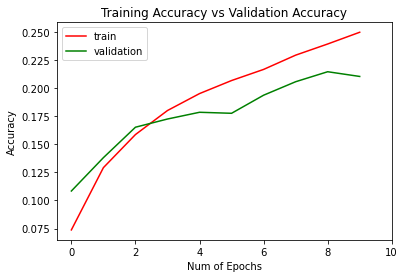

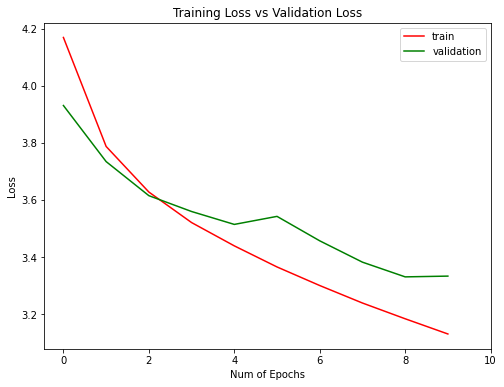

In [15]:
plt.figure(0)  
plt.plot(snn.history['acc'],'r')  
plt.plot(snn.history['val_acc'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(snn.history['loss'],'r')  
plt.plot(snn.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

Como vemos, a priori no generaliza demasiado bien, ya que hay una diferencia de acierto de un 4% aproximadamente.

Matriz de confusión usando Scikit Learn
Una vez que hemos entrenado el modelo, vamos a ver otras métricas. Para ello, crearemos la matriz de confusión y, a partir de ella, veremos las métricas precission, recall y F1-score.

Vamos a hacer una predicción sobre el dataset de validación y, a partir de ésta, generamos la matriz de confusión y mostramos las métricas mencionadas anteriormente.

In [16]:
snn_pred = snn_model.predict(x_test, batch_size=32, verbose=1)  
snn_predicted = np.argmax(snn_pred, axis=1)  

313/313 [==============================] - 1s 4ms/step


Como podemos ver, definimos el mayor valor de la predicción. Lo normal es dar un valor mínimo o bias que defina un resultado como positivo, pero en este caso, lo vamos a hacer simple.

Con la librería Scikit Learn, generamos la matriz de confusión y la dibujamos (aunque el gráfico no es muy bueno debido al numero de etiquetas).

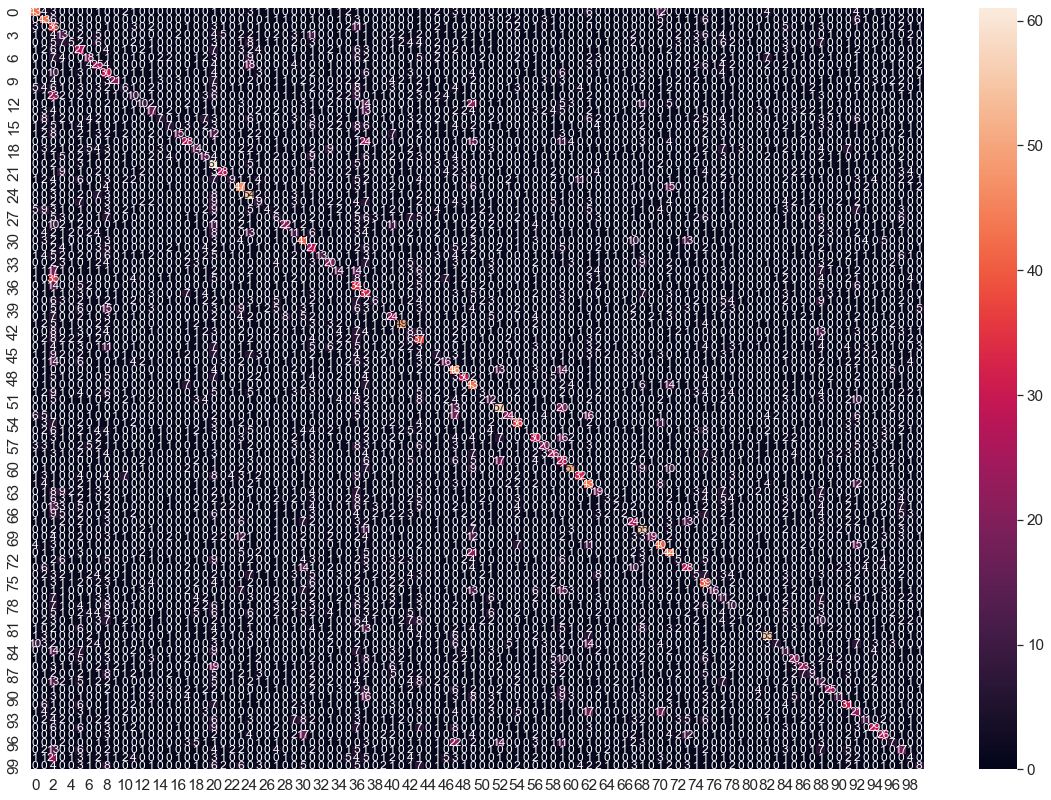

In [17]:
#Creamos la matriz de confusión
snn_cm = confusion_matrix(np.argmax(y_test, axis=1), snn_predicted)

# Visualizamos la matriz de confusión
snn_df_cm = pd.DataFrame(snn_cm, range(100), range(100))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

Y por último, mostramos las métricas:

In [18]:
snn_report = classification_report(np.argmax(y_test, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.41      0.43      0.42       100
           1       0.25      0.43      0.32       100
           2       0.07      0.36      0.12       100
           3       0.11      0.13      0.12       100
           4       0.17      0.05      0.08       100
           5       0.12      0.27      0.17       100
           6       0.23      0.18      0.20       100
           7       0.19      0.25      0.21       100
           8       0.12      0.30      0.17       100
           9       0.53      0.21      0.30       100
          10       0.11      0.06      0.08       100
          11       0.16      0.10      0.12       100
          12       0.29      0.10      0.15       100
          13       0.23      0.17      0.20       100
          14       0.32      0.07      0.11       100
          15       0.19      0.07      0.10       100
          16       0.54      0.15      0.23       100
          17       0.33    

Curva ROC (tasas de verdaderos positivos y falsos positivos)
La curva ROC inicialmente es usada en los clasificadores binarios por ser una buena herramienta para enfrentar la tasa de positivos reales contra los falsos positivos.

Vamos a codificar la curva ROC para clasificación multiclase.

C:\Users\INVITA~1\AppData\Local\Temp/ipykernel_11524/2517534066.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


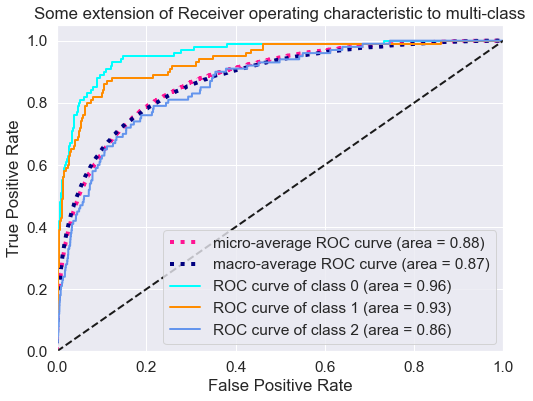

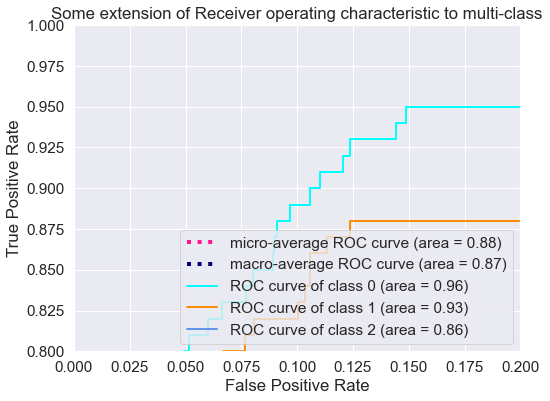

In [19]:
from sklearn.datasets import make_classification  
from sklearn.preprocessing import label_binarize  
from scipy import interp  
from itertools import cycle

n_classes = 100

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()  
tpr = dict()  
roc_auc = dict()  
for i in range(n_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())  
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)  
for i in range(n_classes):  
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr  
tpr["macro"] = mean_tpr  
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(n_classes-97), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)  
plt.xlim(0, 0.2)  
plt.ylim(0.8, 1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(3), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()  

Vamos a ver algunos resultados:

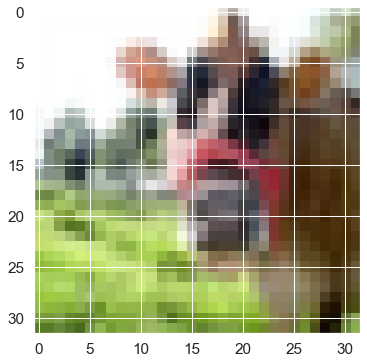

class for image 1: 49
predicted:         49


In [20]:
imgplot = plt.imshow(x_train_original[0])  
plt.show()  
print('class for image 1: ' + str(np.argmax(y_test[0])))  
print('predicted:         ' + str(snn_predicted[0]))  

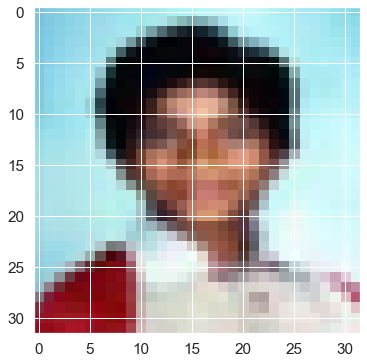

class for image 3: 51
predicted:         2


In [21]:
imgplot = plt.imshow(x_train_original[3])  
plt.show()  
print('class for image 3: ' + str(np.argmax(y_test[3])))  
print('predicted:         ' + str(snn_predicted[3]))  

Finalmente, salvaremos los datos del histórico de entrenamiento para compararlos con otros modelos:

In [24]:
#Histórico
with open('simplenn_history.txt', 'wb') as file_pi:  
  pickle.dump(snn.history, file_pi)

Conclusión sobre este primer Trabajo Realizado
Aunque no está mal para diez epochs, vemos que las gráficas no van a mejorar mucho mas, pues estan empezando a ponerse horizontales, lo que indica que aumentar mucho más las vueltas de entrenamiento no van a mejorar el aprendizaje. Si bien la curva ROC da una buena tasa de positivos reales contra falsos positivos (es decir, cuando especifica una clase, no suele dar un falso positivo), el nivel de acierto es muy bajo para las métricas accuracy, recall y precission.